In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams, trigrams
from nltk import WordNetLemmatizer
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, LSTM, GRU
from keras.regularizers import l1, l2
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

zomato = pd.read_csv("../input/zomato-bangalore-restaurants/zomato.csv", na_values = ["-", ""])
data = zomato.copy()

Using TensorFlow backend.


In [ ]:

grouped = data.groupby(["name", "address"]).agg({"listed_in(type)" : list})
newdata = pd.merge(grouped, data, on = (["name", "address"]))
newdata["listed_in(type)_x"] = newdata["listed_in(type)_x"].astype(str)
newdata.drop_duplicates(subset = ["name", "address", "listed_in(type)_x"], inplace = True)
newdata = newdata.reset_index(drop = True)

In [ ]:

newdata["rating"] = newdata["rate"].str[:3] 
newdata = newdata[newdata.rating != "NEW"] 

newdata = newdata.dropna(subset = ["rating"])

newdata["rating"] = pd.to_numeric(newdata["rating"])


newdata["rating"] = pd.cut(newdata["rating"], bins = [0, 3.0, 3.5, 4.0, 5.0], labels = ["0", "1", "2", "3"])

Our four rating bins (classes) will be 0 to 3 < 3 to 3.5 < 3.5 to 4 < 4 to 5. To make label encoding easier later, we'll label these classes 0, 1, 2, 3. We can think of these as Very Low, Low, Medium and High.

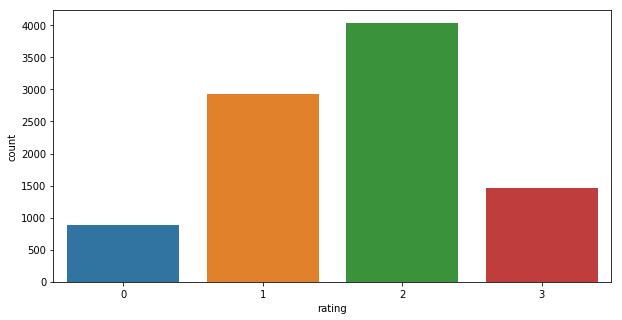

In [ ]:
plt.figure(figsize = (10, 5))
sns.countplot(newdata["rating"])
plt.show()

In [ ]:

newdata.describe(include = "all")

,name,address,listed_in(type)_x,url,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type)_y,listed_in(city),rating
count,9316,9316,9316,9316,9316,9316,9316,9316.000000,9149,9316,9279,4577,9313,9284,9316,9316,9316,9316,9316
unique,6512,8676,870,9316,2,2,59,NaN,8381,92,86,4249,2246,63,8964,1990,7,30,4
top,Cafe Coffee Day,Delivery Only,"['Delivery', 'Dine-out']",https://www.zomato.com/bangalore/laddoos-elect...,Yes,No,3.7/5,NaN,080 43334321,Whitefield,Quick Bites,Biryani,North Indian,400,[],[],Delivery,BTM,2
freq,49,21,872,1,5705,8393,706,NaN,55,617,3445,47,484,1370,332,7314,6519,1115,4037
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.149420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,673.984948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will use the reviews_list, menu_item, dish_liked and cuisines columns for our analysis.

First, we will look at the customer reviews and pull out the most common words and phrases. Next, we will analyse cuisine listings and identify cuisines that are rare in Bangalore. Finally we will build a neural network with all four features to predict restaurant ratings.

In [ ]:

reviews_data = newdata[["reviews_list", "rating"]]

reviews_data["reviews_list"][0]


'[(\'Rated 5.0\', "RATED\\n  Had an egg chicken roll and a paneer roll... Really yummy... A must visit place... It would be good if you guys can keep the shop open on Sunday\'s as well.. Good luck... :-)"), (\'Rated 5.0\', \'RATED\\n  Not just the Roll but the filling tastes great. I would highly recommend to others to try their rolls. Owners hospitality is also good and very friendly.\'), (\'Rated 4.5\', \'RATED\\n  Very nice place complete value for money ? Highly recommend.Must visit for any foodie . I would recommend the egg chicken roll . #feeltheroll\'), (\'Rated 5.0\', \'RATED\\n  Had an amazing mouth-watering ?chicken roll?Worth every bite..A must try for every foodie?A variety of rolls and sandwiches are available as well .. A budding rafflesia ?\')]'

In [ ]:

reviews_data["reviews_list"] = reviews_data["reviews_list"].apply(lambda x: x.lower())


tokenizer = regextoken("[a-zA-Z]+") 
review_tokens = reviews_data["reviews_list"].apply(tokenizer.tokenize)
print(review_tokens[0])

['rated', 'rated', 'n', 'had', 'an', 'egg', 'chicken', 'roll', 'and', 'a', 'paneer', 'roll', 'really', 'yummy', 'a', 'must', 'visit', 'place', 'it', 'would', 'be', 'good', 'if', 'you', 'guys', 'can', 'keep', 'the', 'shop', 'open', 'on', 'sunday', 's', 'as', 'well', 'good', 'luck', 'rated', 'rated', 'n', 'not', 'just', 'the', 'roll', 'but', 'the', 'filling', 'tastes', 'great', 'i', 'would', 'highly', 'recommend', 'to', 'others', 'to', 'try', 'their', 'rolls', 'owners', 'hospitality', 'is', 'also', 'good', 'and', 'very', 'friendly', 'rated', 'rated', 'n', 'very', 'nice', 'place', 'complete', 'value', 'for', 'money', 'highly', 'recommend', 'must', 'visit', 'for', 'any', 'foodie', 'i', 'would', 'recommend', 'the', 'egg', 'chicken', 'roll', 'feeltheroll', 'rated', 'rated', 'n', 'had', 'an', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'a', 'must', 'try', 'for', 'every', 'foodie', 'a', 'variety', 'of', 'rolls', 'and', 'sandwiches', 'are', 'available', 'as', 'w

In [ ]:
# Importing and examining the English stopwords directory 
stop = stopwords.words("english")
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Adding custom words to stopwords 
stop.extend(["rated", "n", "nan", "x"])

review_tokens = review_tokens.apply(lambda x: [token for token in x if token not in stop])

all_reviews = review_tokens.astype(str).str.cat()
cleaned_reviews = tokenizer.tokenize(all_reviews)


fd = FreqDist()
for word in cleaned_reviews:
    fd[word] += 1
    
fd.most_common(5)

[('good', 150929),
 ('food', 147551),
 ('place', 139169),
 ('chicken', 68678),
 ('ordered', 50928)]

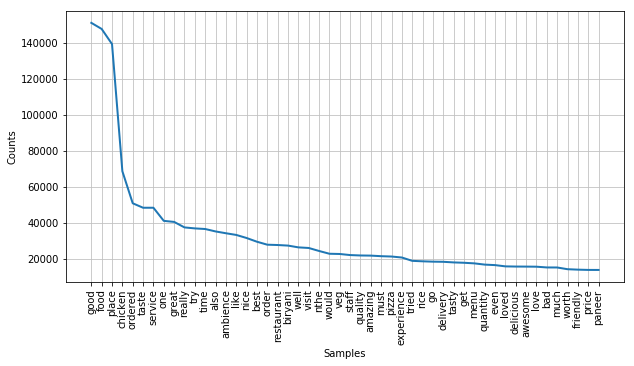

In [ ]:
# Plotting the top 50 most frequent words
plt.figure(figsize = (10, 5))
fd.plot(50)
plt.show()

### Observations
Of the 50 most frequent words across customer reviews, six reveal food preferences: **chicken, biryani, veg, pizza, rice, paneer**. The only negative word in the top 50 is "bad".

Factors contributing to restaurant experience are mentioned in the following (descending) order of frequency: place > taste > service > time > ambience > staff > quality > delivery > menu > quantity > friendly.

Now let us repeat the analysis on a bi-gram level. Bi-grams are pairs of words which can provide better context than individual words.

In [ ]:
bigrams = bigrams(cleaned_reviews)

fd_bigrams = FreqDist()
for bigram in bigrams:
    fd_bigrams[bigram] += 1
fd_bigrams.most_common(5)

[(('must', 'try'), 10719),
 (('really', 'good'), 9973),
 (('good', 'food'), 9939),
 (('food', 'good'), 9585),
 (('good', 'place'), 7871)]

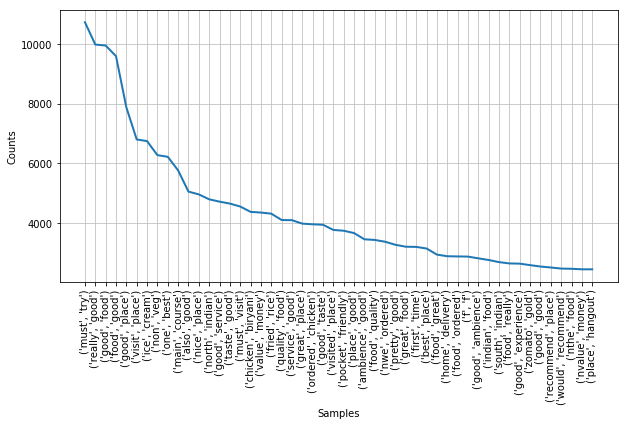

In [ ]:
plt.figure(figsize = (10, 5))
fd_bigrams.plot(50)
plt.show()


### Observations

We have some new insights! Food items/preferences mentioned in the top 50 bigrams are **ice cream, non veg, North Indian, chicken biryani, fried rice, chicken and South Indian**. Top six bigrams related to restaurant experience: good food > good place > good service > value (for) money > pocket friendly > ambience good. 

There's a key insight here: **the expense factor, which was missed by individual word frequency counts, was picked up by the bigram frequency counts.**

Zomato might also be happy to know their membership program "Zomato Gold" is in the top 50 bigrams, with 2593 mentions in the customer reviews.

What about trigrams? 

In [ ]:
trigrams = trigrams(cleaned_reviews)

fd_trigrams = FreqDist()
for trigram in trigrams:
    fd_trigrams[trigram] += 1

fd_trigrams.most_common(5)

[(('xa', 'xa', 'xa'), 1975),
 (('north', 'indian', 'food'), 1707),
 (('f', 'f', 'f'), 1681),
 (('must', 'visit', 'place'), 1666),
 (('veg', 'non', 'veg'), 1634)]

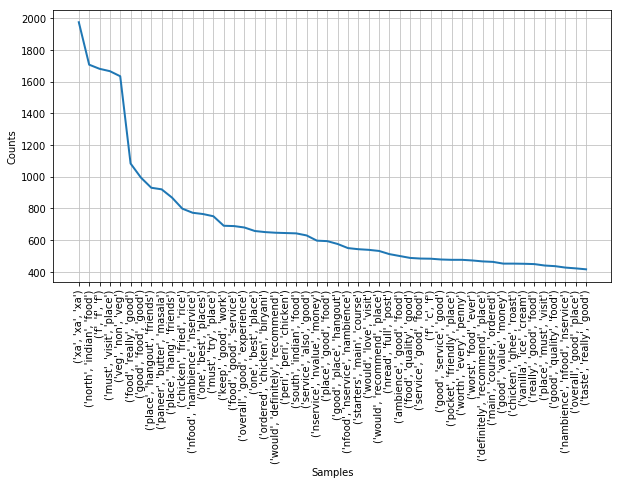

In [ ]:
plt.figure(figsize = (10, 5))
fd_trigrams.plot(50)
plt.show()

### Observations
There appears to be some bad data (strings of "xa xa xa") somewhere in the reviews, but we'll ignore that. The specific food preferences we can see here are **paneer butter masala, chicken fried rice, chicken biryani, peri peri chicken and chicken ghee roast**. Bangalore is really into chicken.

On restaurant experience: a specific insight revealed by the trigrams is that **many people are looking for places to hang out with their friends**. 

We also see a variety of positive trigrams like "must visit place", "food really good", "service also good" and "worth every penny". However, there is only one negative trigram in the top 50 - "worst food ever".

We now have plenty of insights into customer preferences and experiences, and will move onto an analysis of Bangalore's cuisines.

In [ ]:
cuisines = newdata[["cuisines", "rating"]]
cuisines["cuisines"] = cuisines["cuisines"].astype(str)

cuisines["cuisines"] = cuisines["cuisines"].apply(lambda x: x.lower())

cuisine_tokens = cuisines["cuisines"].apply(tokenizer.tokenize)
all_cuisines = cuisine_tokens.astype(str).str.cat()
cleaned_cuisines = tokenizer.tokenize(all_cuisines)

fd_cuisine = FreqDist()
for cuisine in cleaned_cuisines:
    fd_cuisine[cuisine] += 1
    
print(fd_cuisine.most_common(50))

[('indian', 5506), ('north', 3860), ('chinese', 2836), ('food', 2512), ('south', 1633), ('fast', 1602), ('biryani', 1285), ('desserts', 985), ('beverages', 842), ('continental', 821), ('cafe', 674), ('street', 605), ('italian', 501), ('bakery', 495), ('pizza', 393), ('andhra', 379), ('ice', 374), ('cream', 374), ('burger', 369), ('seafood', 320), ('mughlai', 305), ('rolls', 297), ('momos', 246), ('kerala', 244), ('mithai', 206), ('juices', 202), ('american', 200), ('arabian', 193), ('thai', 185), ('asian', 183), ('salad', 179), ('kebab', 174), ('sandwich', 167), ('finger', 159), ('healthy', 145), ('bbq', 126), ('mangalorean', 111), ('bengali', 106), ('european', 104), ('mexican', 98), ('mediterranean', 86), ('steak', 75), ('hyderabadi', 69), ('tea', 68), ('tibetan', 54), ('japanese', 43), ('chettinad', 38), ('chicken', 32), ('vietnamese', 31), ('rajasthani', 29)]


### Observations
One must be careful when interpreting these lists. For example, "dogs" can't be a cuisine but the preceding word "hot" tells us that the cuisine is "hot dogs". Another tricky one is Cantonese, which comes under Chinese and so might not really be rare.

We've done our reviews and cuisines analysis and will now prepare all the text in the dataset for feeding into a neural network.

## Text Preprocessing

In [ ]:

newdata[["reviews_list", "menu_item", "dish_liked", "cuisines"]] = newdata[["reviews_list", "menu_item", "dish_liked", "cuisines"]].astype("str")
newdata["text"] = newdata["reviews_list"] + " " + newdata["menu_item"] + " " + newdata["dish_liked"] + " " + newdata["cuisines"]
text_data = newdata[["text", "rating"]]

text_data["text"] = text_data["text"].apply(lambda x: x.lower())
tokens = text_data["text"].apply(tokenizer.tokenize) 
tokens = tokens.apply(lambda x: [token for token in x if token not in stop])


In [ ]:
print(tokens[0])

['egg', 'chicken', 'roll', 'paneer', 'roll', 'really', 'yummy', 'must', 'visit', 'place', 'would', 'good', 'guys', 'keep', 'shop', 'open', 'sunday', 'well', 'good', 'luck', 'roll', 'filling', 'tastes', 'great', 'would', 'highly', 'recommend', 'others', 'try', 'rolls', 'owners', 'hospitality', 'also', 'good', 'friendly', 'nice', 'place', 'complete', 'value', 'money', 'highly', 'recommend', 'must', 'visit', 'foodie', 'would', 'recommend', 'egg', 'chicken', 'roll', 'feeltheroll', 'amazing', 'mouth', 'watering', 'chicken', 'roll', 'worth', 'every', 'bite', 'must', 'try', 'every', 'foodie', 'variety', 'rolls', 'sandwiches', 'available', 'well', 'budding', 'rafflesia', 'fast', 'food']


In [ ]:

lmtzr = WordNetLemmatizer()
def lem(text):
    return [lmtzr.lemmatize(word) for word in text]

tokens_new = tokens.apply(lem)

In [ ]:
le = LabelEncoder()
target = le.fit_transform(text_data["rating"])
target = to_categorical(target)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(tokens_new, target, test_size = 0.3, random_state = 0, stratify = target)


t = Tokenizer() 
t.fit_on_texts(X_train)

vocab_size = len(t.word_index) + 1
print(vocab_size)

46123


In [ ]:

train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)
train_padded = pad_sequences(train_sequences, maxlen=500)
test_padded = pad_sequences(test_sequences, maxlen=500)

### Word embedding 
We'll use Google's pre-trained Word2Vec word embeddings.

In [ ]:


word_vectors = KeyedVectors.load_word2vec_format('../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)

embedding_dim = 300 


embedding_matrix = np.zeros((vocab_size, embedding_dim)) 


for word, i in t.word_index.items(): 
    try:
        # get the Word2Vec vector representation for that word
        embedding_vector = word_vectors[word] 

        embedding_matrix[i] = embedding_vector 

    except KeyError: 
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)

In [ ]:
embedding_matrix.shape

(46123, 300)

In [ ]:
# Examining the words embeddings - vector representations of words
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.18164062,  0.16503906, -0.16601562, ...,  0.15917969,
         0.12792969,  0.00222778],
       [ 0.04052734,  0.0625    , -0.01745605, ..., -0.15625   ,
         0.00193024, -0.06982422],
       ...,
       [-0.12304688, -0.23925781,  0.25976562, ...,  0.06201172,
         0.14746094,  0.12011719],
       [-0.09520624,  0.75744784, -0.0824335 , ...,  0.22752493,
         0.04909362, -0.49173217],
       [ 0.09049165, -1.06974566,  0.42920093, ...,  0.04468418,
         1.34594317, -0.38823108]])

## Model Building

In [ ]:
# Building an LSTM neural network

warnings.filterwarnings("ignore")
max_length = 500 

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights = [embedding_matrix], trainable = False))
model.add(LSTM(100, activation = "tanh"))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = "adam", metrics=['accuracy'])
model.fit(train_padded, y_train, validation_data=(test_padded, y_test), epochs=15, batch_size=512)

Train on 6521 samples, validate on 2795 samples
Epoch 1/15
6521/6521 [==============================] - 8s 1ms/step - loss: 1.2629 - accuracy: 0.4240 - val_loss: 1.1785 - val_accuracy: 0.4923
Epoch 2/15
6521/6521 [==============================] - 8s 1ms/step - loss: 1.1399 - accuracy: 0.5039 - val_loss: 1.0858 - val_accuracy: 0.5070
Epoch 3/15
6521/6521 [==============================] - 7s 1ms/step - loss: 1.0600 - accuracy: 0.5209 - val_loss: 1.0296 - val_accuracy: 0.5474
Epoch 4/15
6521/6521 [==============================] - 7s 1ms/step - loss: 1.0345 - accuracy: 0.5398 - val_loss: 1.0110 - val_accuracy: 0.5488
Epoch 5/15
6521/6521 [==============================] - 7s 1ms/step - loss: 1.0055 - accuracy: 0.5528 - val_loss: 1.0019 - val_accuracy: 0.5606
Epoch 6/15
6521/6521 [==============================] - 7s 1ms/step - loss: 0.9915 - accuracy: 0.5619 - val_loss: 0.9867 - val_accuracy: 0.5674
Epoch 7/15
6521/6521 [==============================] - 7s 1ms/step - loss: 0.9719 - acc

### Evaluation

In [ ]:
# Predicting on the train data
pred_train = model.predict(train_padded)
pred_train = np.argmax(pred_train, axis=1)
y_train = np.argmax(y_train, axis=1)
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.56      0.05      0.09       619
           1       0.65      0.67      0.66      2050
           2       0.63      0.72      0.68      2826
           3       0.72      0.78      0.75      1026

    accuracy                           0.65      6521
   macro avg       0.64      0.56      0.54      6521
weighted avg       0.64      0.65      0.63      6521



In [ ]:
# Predicting on the test data
pred_test = model.predict(test_padded)
pred_test = np.argmax(pred_test, axis=1)
y_test = np.argmax(y_test, axis = 1)
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.47      0.03      0.06       265
           1       0.57      0.60      0.58       879
           2       0.56      0.63      0.59      1211
           3       0.62      0.69      0.65       440

    accuracy                           0.57      2795
   macro avg       0.56      0.49      0.47      2795
weighted avg       0.56      0.57      0.55      2795



## Results summary
By applying text mining techniques to customer reviews and other data, **we discovered common food preferences which became more specific as we progressed (dish names)**. **We also noted which aspects of a restaurant people care about and in what order of priority. Then we identified the most and least common cuisines in the city along with their prevalence.**

The text mining activity was interesting from both a data science perspective and a business perspective, as it showed the usefulness of different NLTK tools and revealed actionable insights.

After processing the text, we fed it to an LSTM network with pre-trained Word2Vec word vectors to see if we could predict the four rating classes we created. Accuracy and average F1 scores were lower than what we got with XGBoost. 
